# Traffic Analysis

### Notebook Summary

In this notebook we will explore data for all traffic collisions in the Los Angeles area starting on January 1, 2010 through 2018, the first full year of legalization. This analysis will speak to the validity of the argument that legalizing recreational marijuana use in the state of California would double the state's number of traffic fatalities.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re

plt.style.use('fivethirtyeight')

### Data Import & Cleaning

For this analysis we requested and received collision data for the Los Angeles area from the California Highway Patrol's Statewide Integrated Traffic Records System (SWITRS). The source data is divided into three files that focus on information about the collisions themselves, the parties involved, and the various victims of the collisions. The anchor of these three datasets is the collisions dataset.

In [2]:
collisions = pd.read_csv('../data/traffic/CollisionRecords.txt', low_memory=False)
print(f'Collisions Shape: {collisions.shape}')

victims = pd.read_csv('../data/traffic/VictimRecords.txt', low_memory=False)
print(f'Victims Shape: {victims.shape}')

parties = pd.read_csv('../data/traffic/PartyRecords.txt', low_memory=False)
print(f'Parties Shape: {parties.shape}')

Collisions Shape: (485055, 76)
Victims Shape: (573372, 10)
Parties Shape: (1031406, 33)


In [3]:
victims.head()

,CASE_ID,PARTY_NUMBER,VICTIM_ROLE,VICTIM_SEX,VICTIM_AGE,VICTIM_DEGREE_OF_INJURY,VICTIM_SEATING_POSITION,VICTIM_SAFETY_EQUIP_1,VICTIM_SAFETY_EQUIP_2,VICTIM_EJECTED
0,4392007,2,3,F,25,1,9,P,-,0
1,4392008,1,2,F,83,1,6,M,G,0
2,4392008,3,2,-,998,0,3,M,G,0
3,4392008,3,2,-,998,0,6,M,G,0
4,4392021,2,3,F,65,1,9,-,-,1


In [4]:
parties.head()

,CASE_ID,PARTY_NUMBER,PARTY_TYPE,AT_FAULT,PARTY_SEX,PARTY_AGE,PARTY_SOBRIETY,PARTY_DRUG_PHYSICAL,DIR_OF_TRAVEL,PARTY_SAFETY_EQUIP_1,...,MOVE_PRE_ACC,VEHICLE_YEAR,VEHICLE_MAKE,STWD_VEHICLE_TYPE,CHP_VEH_TYPE_TOWING,CHP_VEH_TYPE_TOWED,RACE,INATTENTION,SPECIAL_INFO_F,SPECIAL_INFO_G
0,4391974,1,1,N,M,68,G,G,S,L,...,N,1994.0,HONDA,A,01,00,W,NaN,-,-
1,4392007,1,1,N,-,998,G,G,N,-,...,B,NaN,-,-,99,00,NaN,NaN,-,-
2,4392007,2,2,Y,F,25,B,-,W,-,...,B,NaN,-,N,60,00,O,NaN,-,-
3,4392008,1,1,Y,M,39,A,-,N,M,...,B,2005.0,TOYOTA,A,01,00,W,-,-,-
4,4392008,2,1,N,F,32,A,-,E,L,...,B,2007.0,DODGE,-,-,00,W,NaN,-,-


In [5]:
collisions.head()

,CASE_ID,ACCIDENT_YEAR,PROC_DATE,JURIS,COLLISION_DATE,COLLISION_TIME,OFFICER_ID,REPORTING_DISTRICT,DAY_OF_WEEK,CHP_SHIFT,...,COUNT_PED_KILLED,COUNT_PED_INJURED,COUNT_BICYCLIST_KILLED,COUNT_BICYCLIST_INJURED,COUNT_MC_KILLED,COUNT_MC_INJURED,PRIMARY_RAMP,SECONDARY_RAMP,LATITUDE,LONGITUDE
0,4391974,2010,20100421,1942,20100106,705,38444,0567,3,5,...,0,0,0,0,0,0,-,-,NaN,NaN
1,4392007,2010,20110324,1942,20100115,400,37724,0504,5,5,...,1,0,0,0,0,0,-,-,NaN,NaN
2,4392008,2010,20100219,1942,20100103,1405,38876,0527,7,5,...,0,0,0,0,0,0,-,-,NaN,NaN
3,4392021,2010,20100219,1942,20100127,820,35199,2017,3,5,...,1,0,0,0,0,0,-,-,NaN,NaN
4,4392071,2010,20120123,1942,20100103,2300,39291,0327,7,5,...,1,0,0,0,0,0,-,-,NaN,NaN


The first few rows of the collisions dataset all have null values for `Latitude` and `Longitude`, so we will check to see how pervasive those locational nulls will be in this set.

In [6]:
collisions.shape[0] - collisions.LONGITUDE.isnull().sum()

154097

Those roughly 154,000 rows only represent about a third of our reported collisions, so unfortunately we will have to handle the collisions without that data and will not include `Latitude` and `Longitude` in the columns we keep from this dataset.

Next we'll check to see what other features are included in the collisions dataset.

In [7]:
collisions.columns

Index(['CASE_ID', 'ACCIDENT_YEAR', 'PROC_DATE', 'JURIS', 'COLLISION_DATE',
       'COLLISION_TIME', 'OFFICER_ID', 'REPORTING_DISTRICT', 'DAY_OF_WEEK',
       'CHP_SHIFT', 'POPULATION', 'CNTY_CITY_LOC', 'SPECIAL_COND', 'BEAT_TYPE',
       'CHP_BEAT_TYPE', 'CITY_DIVISION_LAPD', 'CHP_BEAT_CLASS', 'BEAT_NUMBER',
       'PRIMARY_RD', 'SECONDARY_RD', 'DISTANCE', 'DIRECTION', 'INTERSECTION',
       'WEATHER_1', 'WEATHER_2', 'STATE_HWY_IND', 'CALTRANS_COUNTY',
       'CALTRANS_DISTRICT', 'STATE_ROUTE', 'ROUTE_SUFFIX', 'POSTMILE_PREFIX',
       'POSTMILE', 'LOCATION_TYPE', 'RAMP_INTERSECTION', 'SIDE_OF_HWY',
       'TOW_AWAY', 'COLLISION_SEVERITY', 'NUMBER_KILLED', 'NUMBER_INJURED',
       'PARTY_COUNT', 'PRIMARY_COLL_FACTOR', 'PCF_CODE_OF_VIOL',
       'PCF_VIOL_CATEGORY', 'PCF_VIOLATION', 'PCF_VIOL_SUBSECTION',
       'HIT_AND_RUN', 'TYPE_OF_COLLISION', 'MVIW', 'PED_ACTION',
       'ROAD_SURFACE', 'ROAD_COND_1', 'ROAD_COND_2', 'LIGHTING',
       'CONTROL_DEVICE', 'CHP_ROAD_TYPE', 'PEDESTRIAN_

Much of this information will either be redundant (we have already narrowed our focus to just the Los Angeles area, eliminating the need for features like `JURIS`, `POPULATION`, and `CNTY_CITY_LOC`) or irrelevant to the narrow scope of our investigation.

In [8]:
collisions_keep_cols = ['CASE_ID', 'ACCIDENT_YEAR', 'COLLISION_DATE',
                        'WEATHER_1', 'WEATHER_2', 'COLLISION_SEVERITY',
                        'NUMBER_KILLED', 'PRIMARY_COLL_FACTOR',
                        'PCF_VIOL_CATEGORY', 'ROAD_SURFACE', 'LIGHTING',
                        'ALCOHOL_INVOLVED']
collisions = collisions[collisions_keep_cols]

We will check for any nulls in our remaining columns.

In [9]:
collisions.isnull().sum()

CASE_ID                     0
ACCIDENT_YEAR               0
COLLISION_DATE              0
WEATHER_1                   0
WEATHER_2                   0
COLLISION_SEVERITY          0
NUMBER_KILLED               0
PRIMARY_COLL_FACTOR         0
PCF_VIOL_CATEGORY           0
ROAD_SURFACE                0
LIGHTING                    0
ALCOHOL_INVOLVED       443179
dtype: int64

According to CHP, the `ALCOHOL_INVOLVED` column will either be marked Y or blank, so we will presume the nulls represent an entry of "No" and fill them accordingly.

In [10]:
collisions.ALCOHOL_INVOLVED.fillna('N', inplace=True)

Next we will consider the `parties` dataset's features.

In [11]:
parties.columns

Index(['CASE_ID', 'PARTY_NUMBER', 'PARTY_TYPE', 'AT_FAULT', 'PARTY_SEX',
       'PARTY_AGE', 'PARTY_SOBRIETY', 'PARTY_DRUG_PHYSICAL', 'DIR_OF_TRAVEL',
       'PARTY_SAFETY_EQUIP_1', 'PARTY_SAFETY_EQUIP_2', 'FINAN_RESPONS',
       'SP_INFO_1', 'SP_INFO_2', 'SP_INFO_3', 'OAF_VIOLATION_CODE',
       'OAF_VIOL_CAT', 'OAF_VIOL_SECTION', 'OAF_VIOLATION_SUFFIX', 'OAF_1',
       'OAF_2', 'PARTY_NUMBER_KILLED', 'PARTY_NUMBER_INJURED', 'MOVE_PRE_ACC',
       'VEHICLE_YEAR', 'VEHICLE_MAKE', 'STWD_VEHICLE_TYPE',
       'CHP_VEH_TYPE_TOWING', 'CHP_VEH_TYPE_TOWED', 'RACE', 'INATTENTION',
       'SPECIAL_INFO_F', 'SPECIAL_INFO_G'],
      dtype='object')

For our purposes we are primarily interested in whether a particular party was at fault in the collision, and if so we are interested in whether that party was under the influence of any drugs or alcohol, so those are the features we will keep.

In [12]:
parties_keep_cols = ['CASE_ID', 'AT_FAULT', 'PARTY_SOBRIETY',
                     'PARTY_DRUG_PHYSICAL', 'OAF_VIOL_CAT']
parties = parties[parties_keep_cols]

Lastly, we will look at the features of the `victims` dataset.

In [13]:
victims.columns

Index(['CASE_ID', 'PARTY_NUMBER', 'VICTIM_ROLE', 'VICTIM_SEX', 'VICTIM_AGE',
       'VICTIM_DEGREE_OF_INJURY', 'VICTIM_SEATING_POSITION',
       'VICTIM_SAFETY_EQUIP_1', 'VICTIM_SAFETY_EQUIP_2', 'VICTIM_EJECTED'],
      dtype='object')

The features in the `victims` dataset do not provide any additional information that is relevant to our specific interest, so we will move forward with the `collisions` and `parties` datasets.

### Visualizations

To eliminate any potential distortions from as-yet-incomplete 2019 data, we will focus only on collisions that took place through the year 2018.

In [14]:
no2019 = (collisions['ACCIDENT_YEAR'] != 2019)
collisions[no2019].groupby('ACCIDENT_YEAR')['NUMBER_KILLED'].sum()

ACCIDENT_YEAR
2010    230
2011    206
2012    254
2013    251
2014    245
2015    241
2016    323
2017    284
2018    256
Name: NUMBER_KILLED, dtype: int64

Now that we have the total fatalities by year, we will plot them below.

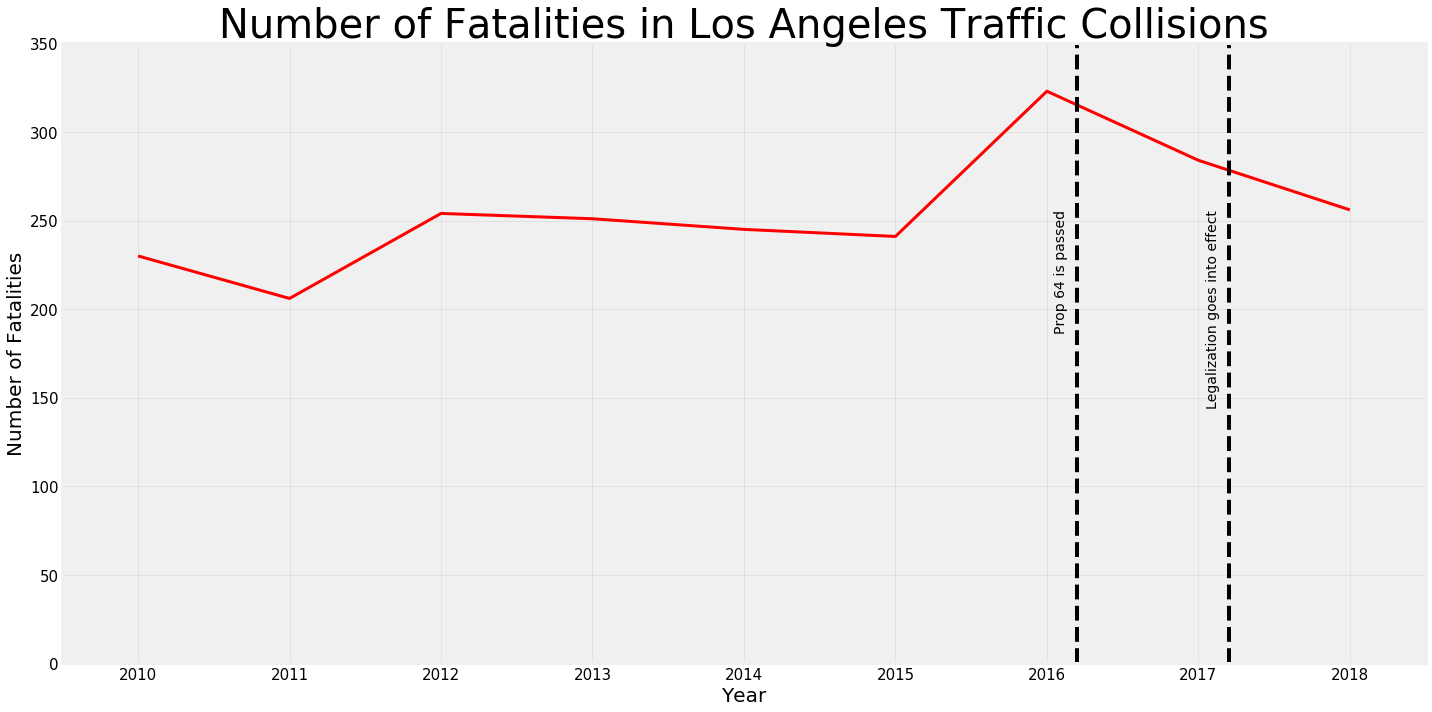

In [15]:
plt.figure(figsize=(20,10))
plt.plot(collisions[no2019].groupby('ACCIDENT_YEAR')['NUMBER_KILLED'].sum(), color='red', linewidth=3)
plt.xticks(collisions[no2019].ACCIDENT_YEAR.unique(), fontsize=15)
plt.yticks(fontsize=15)
plt.title('Number of Fatalities in Los Angeles Traffic Collisions', fontsize=40)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Number of Fatalities', fontsize=20)
plt.ylim(bottom=0, top=350)
plt.xlim(left=2009.5, right=2018.5)
plt.grid(alpha=.4)

plt.axvline(x=2016.2, ymin=0, ymax=350, color='k', linestyle='--')
plt.text(x=2016.05, y=250, s='Prop 64 is passed', rotation=90, fontsize=14)
plt.axvline(x=2017.2, ymin=0, ymax=350, color='k', linestyle='--')
plt.text(x=2017.05, y=250, s='Legalization goes into effect', rotation=90, fontsize=14);

plt.tight_layout()
plt.savefig('../visualizations/fatalities.png');

From this plot we can clearly see that not only did the raw number of LA traffic fatalities not double in 2018, the number actually continued a downward trend back toward its steady hold from 2012-2015. While Los Angeles did see a spike in traffic fatalities recently, that spike occurred in 2016 before legalization went into effect.

Next we want to examine the impact of drug use on these fatal collisions. To do that we will merge the relevant portions of the `parties` dataframe (those instances where one party was deemed to be at fault in the collision) with the `collisions` dataframe.

In [16]:
atfault_collisions = parties[(parties.AT_FAULT == 'Y')].merge(collisions)

The `PARTY_DRUG_PHYSICAL` feature will be our main point of interest in determining the impact of drugs on these fatal collisions, so we will take a closer look at it.

In [17]:
atfault_collisions.PARTY_DRUG_PHYSICAL.value_counts()

-    317446
G    115056
H     11777
I      3162
E      2471
F       536
Name: PARTY_DRUG_PHYSICAL, dtype: int64

That's a large portion of the dataset that has a value of - for "Not Stated," so we will see if we can glean any other insights about that absence before moving forward.

In [18]:
atfault_collisions.groupby('NUMBER_KILLED')['PARTY_DRUG_PHYSICAL'].value_counts()

NUMBER_KILLED  PARTY_DRUG_PHYSICAL
0              -                      316339
               G                      114451
               H                       11754
               I                        3155
               E                        2105
               F                         531
1              -                        1061
               G                         582
               E                         343
               H                          23
               I                           7
               F                           5
2              -                          34
               G                          21
               E                          18
3              -                           8
               E                           5
               G                           1
4              -                           4
               G                           1
Name: PARTY_DRUG_PHYSICAL, dtype: int64

Nearly 99.7% of the instances of "Not Stated" occurred in collisions where there were no fatalities, so we will carry on.

According to CHP, a value of E in the `PARTY_DRUG_PHYSICAL` column signifies that the party was under the influence of drugs, so we will create a mask for that value and visualize the number of fatalities where the at-fault party was found to be under the influence of drugs, compared to the total number of all Los Angeles traffic fatalities for each year.

In [19]:
drug_influence = (atfault_collisions['PARTY_DRUG_PHYSICAL'] == 'E')

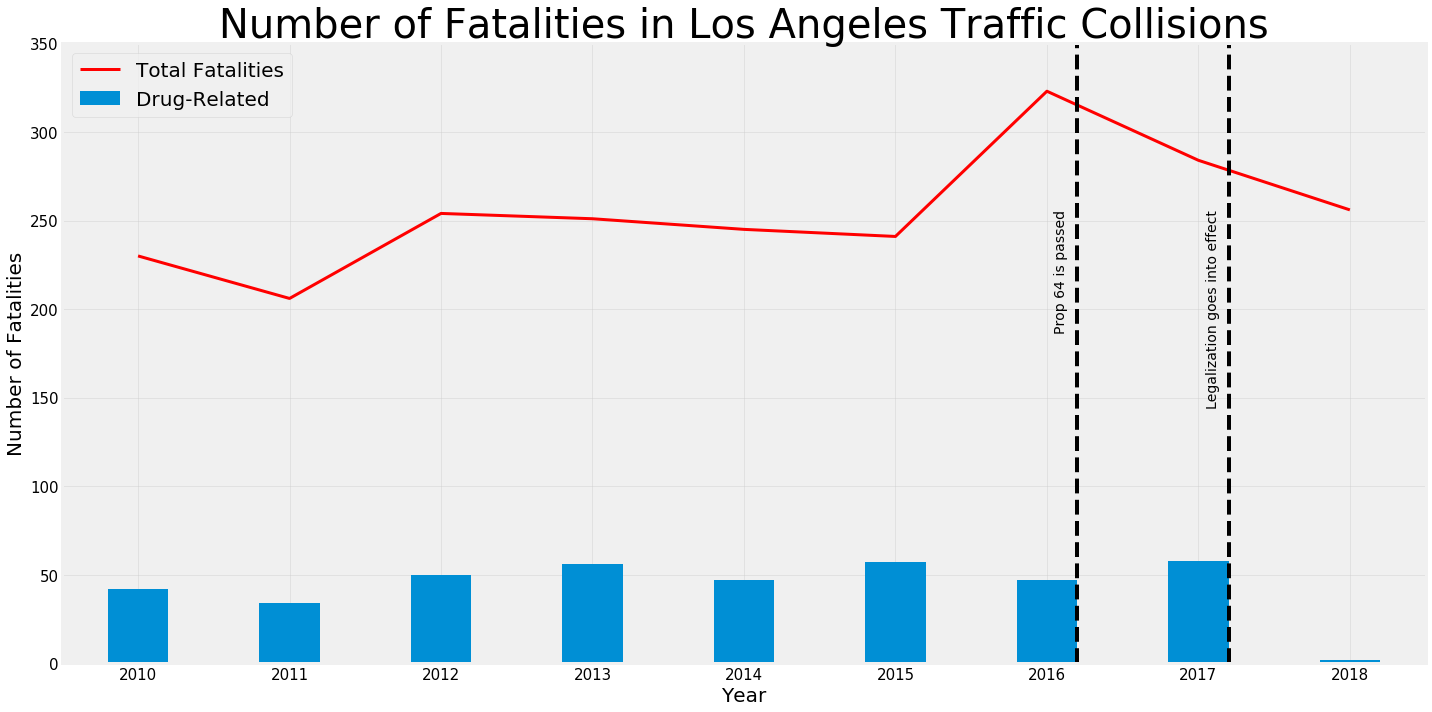

In [20]:
plt.figure(figsize=(20,10))
plt.plot(collisions[no2019].groupby('ACCIDENT_YEAR')['NUMBER_KILLED'].sum(), color='red', linewidth=3)
plt.xticks(ticks=collisions[no2019].ACCIDENT_YEAR.unique(), labels=collisions[no2019].ACCIDENT_YEAR.unique(), fontsize=15)
plt.yticks(fontsize=15)

for year in collisions[no2019].ACCIDENT_YEAR.unique():
    plt.bar(height=atfault_collisions[(atfault_collisions['ACCIDENT_YEAR'] == year) & drug_influence]['NUMBER_KILLED'].sum(),
            x=year, color='C0', width=.4)

plt.title('Number of Fatalities in Los Angeles Traffic Collisions', fontsize=40)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Number of Fatalities', fontsize=20)
plt.ylim(bottom=0, top=350)
plt.xlim(left=2009.5, right=2018.5)
plt.grid(alpha=.4)

plt.legend(['Total Fatalities', 'Drug-Related'], fontsize=20, loc=2)

plt.axvline(x=2016.2, ymin=0, ymax=350, color='k', linestyle='--')
plt.text(x=2016.05, y=250, s='Prop 64 is passed', rotation=90, fontsize=14)
plt.axvline(x=2017.2, ymin=0, ymax=350, color='k', linestyle='--')
plt.text(x=2017.05, y=250, s='Legalization goes into effect', rotation=90, fontsize=14);

plt.tight_layout()
plt.savefig('../visualizations/fatalities_with_drugs.png');

The thing that jumps out immediately from this visualization is that the number of fatal collisions where the at-fault party was under the influence of drugs nearly vanished completely during 2018 when legalization went into effect. It's possible that this could be the result of incomplete or backlogged data at CHP, but even if we suppose that the 2018 number will increase in the future, it would seem reasonable to conclude that there has not been a dramatic increase in drug-related fatalities since legalization went into effect.

Since it's possible that drugs were not the only contributing factor in these collisions we'd like to try to isolate those cases where it was. Since alcohol consumption is a factor that is both likely to overlap with drug use and likely to contribute to a higher rate of collision, we will examine that factor and see how they might be interacting.

In [21]:
alcohol_influence = (atfault_collisions['PARTY_SOBRIETY'] == 'B')
drugs_only = ((atfault_collisions['PARTY_DRUG_PHYSICAL'] == 'E') & (atfault_collisions['PARTY_SOBRIETY'] != 'B'))
alc_only = ((atfault_collisions['PARTY_DRUG_PHYSICAL'] != 'E') & (atfault_collisions['PARTY_SOBRIETY'] == 'B'))
drugs_and_alc_influence = ((atfault_collisions['PARTY_DRUG_PHYSICAL'] == 'E') & (atfault_collisions['PARTY_SOBRIETY'] == 'B'))

print(f"Fatalities in drug-related collisions: {atfault_collisions[drug_influence]['NUMBER_KILLED'].sum()}")
print(f"Fatalities in alcohol-related collisions: {atfault_collisions[alcohol_influence]['NUMBER_KILLED'].sum()}")
print(f"Fatalities in drug-related collisions where alcohol was not a factor: {atfault_collisions[drugs_only]['NUMBER_KILLED'].sum()}")
print(f"Fatalities in alcohol-related collisions where drugs were not a factor: {atfault_collisions[alc_only]['NUMBER_KILLED'].sum()}")
print(f"Fatalities in collisions where both drugs and alcohol were involved: {atfault_collisions[drugs_and_alc_influence]['NUMBER_KILLED'].sum()}")

Fatalities in drug-related collisions: 394
Fatalities in alcohol-related collisions: 492
Fatalities in drug-related collisions where alcohol was not a factor: 245
Fatalities in alcohol-related collisions where drugs were not a factor: 343
Fatalities in collisions where both drugs and alcohol were involved: 149


The most important distinction here is to establish the overlap of alcohol use in drug-related collisions, so we will revisualize our plot with that additional information.

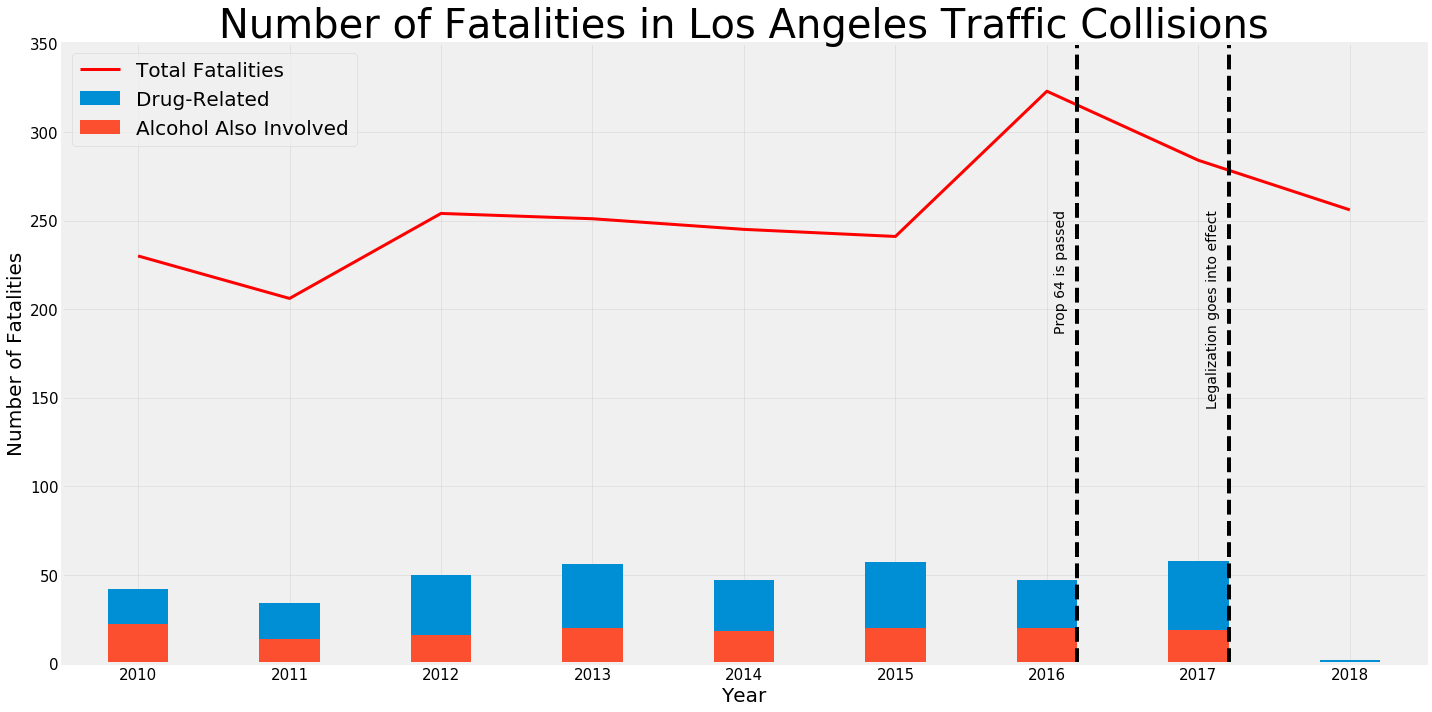

In [22]:
plt.figure(figsize=(20,10))
plt.plot(collisions[no2019].groupby('ACCIDENT_YEAR')['NUMBER_KILLED'].sum(), color='red', linewidth=3)
plt.xticks(ticks=collisions[no2019].ACCIDENT_YEAR.unique(), labels=collisions[no2019].ACCIDENT_YEAR.unique(), fontsize=15)
plt.yticks(fontsize=15)

legend_labels = []
for year in collisions[no2019].ACCIDENT_YEAR.unique():
    drug_fatalities = atfault_collisions[(atfault_collisions['ACCIDENT_YEAR'] == year) & drug_influence]['NUMBER_KILLED'].sum() 
    drug_bar = plt.bar(height=drug_fatalities, x=year, color='C0', width=.4)
    drug_plus_alc_fatalities = atfault_collisions[(atfault_collisions['ACCIDENT_YEAR'] == year) & drugs_and_alc_influence]['NUMBER_KILLED'].sum()
    drug_and_alc_bar = plt.bar(height=drug_plus_alc_fatalities, x=year, color='C1', width=.4)

plt.title('Number of Fatalities in Los Angeles Traffic Collisions', fontsize=40)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Number of Fatalities', fontsize=20)
plt.ylim(bottom=0, top=350)
plt.xlim(left=2009.5, right=2018.5)
plt.grid(alpha=.4)
plt.legend(['Total Fatalities', 'Drug-Related', 'Alcohol Also Involved'], fontsize=20, loc=2)

plt.axvline(x=2016.2, ymin=0, ymax=350, color='k', linestyle='--')
plt.text(x=2016.05, y=250, s='Prop 64 is passed', rotation=90, fontsize=14)
plt.axvline(x=2017.2, ymin=0, ymax=350, color='k', linestyle='--')
plt.text(x=2017.05, y=250, s='Legalization goes into effect', rotation=90, fontsize=14);

plt.tight_layout()
plt.savefig('../visualizations/fatalities_with_alcohol.png');

This visualization does give us some perspective regarding the impact of drug use as an exclusive factor in fatal collisions. While the overlap with alcohol as a contributing factor is noteworthy, the amount of overlap is not enough to dismiss drug use alone as a factor in fatal collisions. That being said, the fact that these collisions have been flagged broadly as involving drug use does call the influence of marijuana specifically into question. Moving forward it would be worthwhile to revisit this subject with more granular data that speaks directly to marijuana's influence separate from other drugs. But for now the fact remains that the projected increases in traffic fatalities after legalization have not happened to date.